In [41]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max.column", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.precision", 3)

#### 1. Load Datasets and familiarize

In [3]:
ratings = pd.read_csv("u.data", sep="\t", names=["user_id", "item_id", "rating", "timestamp"])

movies = pd.read_csv("u.item", sep="|", encoding='latin-1', header=None,
                        names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL",
                               "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime",
                               "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery",
                               "Romance", "Sci-Fi", "Thriller", "War", "Western"])

print(f"Shape of ratings: {ratings.shape}")
print(f"Shape of movies: {movies.shape}")

Shape of ratings: (100000, 4)
Shape of movies: (1682, 24)


In [4]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
movies.head()

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%20(1995),0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(1995),0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995),0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [6]:
movie_ids = movies['movie_id'].unique()
item_ids = ratings['item_id'].unique()

# rating dataset has 19 item_id values that doesn't have an associated title
print(f"Number of items that are not in both dataset: {len(set(movie_ids).symmetric_difference(item_ids))}")

Number of items that are not in both dataset: 0


#### 2. Preprocessing datasets

In [7]:
ratings.drop(["timestamp"], axis=1, inplace=True)
movies.drop(["release_date", "video_release_date", "IMDb_URL", "unknown"], axis=1, inplace=True)

In [8]:
movies[movies["title"].str.contains(", The")].head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
11,12,"Usual Suspects, The (1995)",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
17,18,"White Balloon, The (1995)",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
24,25,"Birdcage, The (1996)",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
25,26,"Brothers McMullen, The (1995)",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
33,34,"Doom Generation, The (1995)",0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [9]:
def move_the(movie_title):
    new_title = "The "
    if ", The" in movie_title:
        parts = movie_title.split(", The")
        new_title = "The " + "".join(parts)
        return new_title
    return movie_title


movies["title"] = movies["title"].apply(move_the).apply(str.strip)

movies[movies["title"].str.contains(", The")].empty

True

In [10]:
movies[movies["title"] == "unknown"]

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# Invert the boolean mask to keep rows where title does not contain 'unknown'
movies = movies[~movies["title"].str.contains("unknown", case=False)]
movies.reset_index(drop=True, inplace=True)

movies.head()

,movie_id,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [12]:
# Create movie tags for scraping
def create_tag(title):
    processed_title = re.sub(r"[^a-zA-Z]", "", title)  # only keep alphabets
    return processed_title.lower()


movies["title_tag"] = movies["title"].apply(create_tag)
movies["title_tag"].values[:5]

array(['toystory', 'goldeneye', 'fourrooms', 'getshorty', 'copycat'],
      dtype=object)

In [13]:
movies.columns

Index(['movie_id', 'title', 'Action', 'Adventure', 'Animation', 'Children's',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'title_tag'],
      dtype='object')

In [14]:
print(f"Number of titles in movies data frame: {movies['title'].nunique()}")
print(f"Number of distinct tags after processing title: {movies['title_tag'].nunique()}")

Number of titles in movies data frame: 1663
Number of distinct tags after processing title: 1649


#### 3. Load Sentiment Score file

In [15]:
average_sentiment = pd.read_csv(r"average_sentiment.csv")
average_sentiment.head()

,tag,average_score
0,101dalmatians,0.200
1,12angrymen,0.203
2,187,0.153
3,1900,0.050
4,20000leaguesunderthesea,0.234


In [16]:
print(f"Number of tags for which scrapping produced results: {average_sentiment['tag'].nunique()}")

Number of tags for which scrapping produced results: 1398


#### 4. Merge all dataframes and preprocess for training

In [17]:
movies_ratings_combined = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')
df = pd.merge(movies_ratings_combined, average_sentiment, left_on='title_tag', right_on='tag', how='inner')
df.shape

(91736, 26)

In [18]:
# Drop duplicate columns
df.drop(["movie_id", "tag"], axis=1, inplace=True)
df.columns

Index(['user_id', 'item_id', 'rating', 'title', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western', 'title_tag', 'average_score'],
      dtype='object')

In [19]:
df.head()

,user_id,item_id,rating,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_tag,average_score
0,196,242,3,Kolya (1996),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,kolya,0.171
1,186,302,3,L.A. Confidential (1997),0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,laconfidential,0.180
2,22,377,1,Heavyweights (1994),0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,heavyweights,0.226
3,244,51,2,Legends of the Fall (1994),0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,legendsofthefall,0.134
4,166,346,1,Jackie Brown (1997),0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,jackiebrown,0.176


In [20]:
df.dtypes

user_id            int64
item_id            int64
rating             int64
title             object
Action             int64
Adventure          int64
Animation          int64
Children's         int64
Comedy             int64
Crime              int64
Documentary        int64
Drama              int64
Fantasy            int64
Film-Noir          int64
Horror             int64
Musical            int64
Mystery            int64
Romance            int64
Sci-Fi             int64
Thriller           int64
War                int64
Western            int64
title_tag         object
average_score    float64
dtype: object

In [21]:
df["title"] = df["title"].str.replace(r"\(|\)", "", regex=True)
df.head()

,user_id,item_id,rating,title,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,title_tag,average_score
0,196,242,3,Kolya 1996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,kolya,0.171
1,186,302,3,L.A. Confidential 1997,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,laconfidential,0.180
2,22,377,1,Heavyweights 1994,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,heavyweights,0.226
3,244,51,2,Legends of the Fall 1994,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,legendsofthefall,0.134
4,166,346,1,Jackie Brown 1997,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,jackiebrown,0.176


In [22]:
# Include both item_id and title_tag to train model 
print(f"Number of unique item id's: {df['item_id'].nunique()}")
print(f"Number of unique title tag's: {df['title_tag'].nunique()}")

Number of unique item id's: 1378
Number of unique title tag's: 1349


In [23]:
# Save movie tags and item ids corresponding to it

# Create a dictionary with unique movie tags as key and item ids as values

tag_id_dict = {}
tags_with_more_than_one_id = []

tags = df["title_tag"].unique()

for tag in tags:
    ids = list(df.loc[df["title_tag"] == tag]["item_id"].unique())
    tag_id_dict[tag] = ids
    if len(ids) > 1:
        tags_with_more_than_one_id.append(tag)

print(f"Number of tags with more than one item id: {len(tags_with_more_than_one_id)}")

# n(tags) < n(title) < n(item_id)

Number of tags with more than one item id: 28


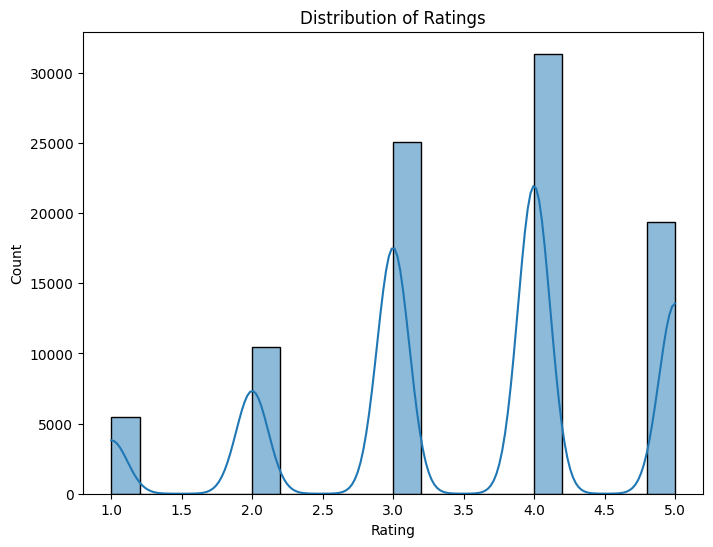

In [24]:
# Check if data is balanced

plt.figure(figsize=(8, 6))

sns.histplot(df["rating"], bins=20, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

Text(0.5, 1.0, 'Correlation Matrix')

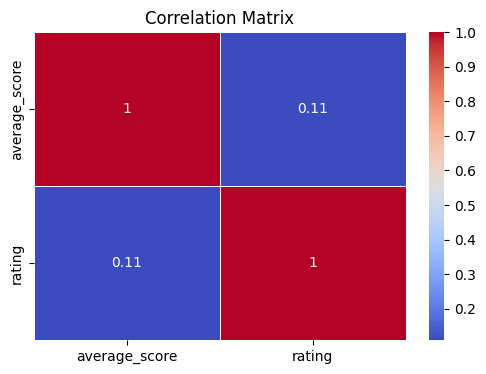

In [25]:
# Correlation matrix - To ensure sentiment score has some correlation with rating
corr_matrix = df[["average_score", "rating"]].corr()

# Heatmap of correlations
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
# plt.show()

#### COLLABORATIVE FILTERING BASED RECOMMENDATION SYSTEM USING SVD

In [26]:
import surprise
from surprise import Dataset, Reader
from surprise import SVD
import surprise.model_selection  # train_test_split
from surprise.model_selection import cross_validate
from surprise import accuracy

In [27]:
# Load the MovieLens dataset
reader = Reader(line_format='user item rating', rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.2, random_state=42)  # 5 pairs of train-test set

In [28]:
# Create model using SVD algorithm for matrix factorization
algo = SVD(random_state=42)

algo.fit(trainset)

predictions = algo.test(testset)
# print(f"RMSE: {accuracy.rmse(predictions)}")

In [29]:
CF_rmse = accuracy.rmse(predictions, verbose=False)
print(f"RMSE: {CF_rmse}")

RMSE: 0.9290492569063128


In [30]:
cv_dict = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=False)
svd_df = pd.DataFrame(cv_dict)
svd_df

,test_rmse,test_mae,fit_time,test_time
0,0.944,0.743,0.599,0.050
1,0.940,0.742,0.644,0.034
2,0.937,0.738,0.541,0.041
3,0.934,0.736,0.569,0.042
4,0.932,0.738,0.541,0.104


In [33]:
# Title to indices conversion for reference and the embedding process
tag_to_index = {title: index for index, title in enumerate(df["title_tag"].unique())}
df["tag_index"] = df["title_tag"].map(tag_to_index)

user_to_index = {user: index for index, user in enumerate(df["user_id"].unique())}
df["user_id_code"] = df["user_id"].map(user_to_index)

item_to_index = {item: index for index, item in enumerate(df["item_id"].unique())}
df["item_id_code"] = df["item_id"].map(item_to_index)

In [34]:
# For a user only predict ratings for items not rated by them yet:
def rate_item_list(user_id):
    user_id_code = user_to_index[user_id]
    exclude_item_list = df[df["user_id"] == user_id_code]["item_id_code"].values
    all_items_list = set(df["item_id_code"].unique())
    item_list = list(all_items_list.difference(exclude_item_list))
    return np.array(item_list)

In [35]:
# Function to generate recommendations for a specific user
def generate_recommendations_cf(user_id, algo, top_n=10):
    # item_ids = movies_ratings_combined["item_id"].unique()
    item_ids = rate_item_list(user_id)  # not rated list
    user_ratings = {}
    for item_id in item_ids:
        rating = algo.predict(str(user_id), item_id)
        user_ratings[item_id] = rating.est

    # Predict ratings for all items for the given user
    # user_ratings = {iid: algo.predict(str(user_id), iid).est for iid in range(1, algo.trainset.n_items)}

    # Sort ratings in descending order
    sorted_ratings = sorted(user_ratings.items(), key=lambda x: x[1], reverse=True)

    # Get the top N recommendations
    top_recommendations = sorted_ratings[:top_n]

    return top_recommendations

In [36]:
# Example: Generate recommendations for a specific user from the test set
user_id = 22  # Example user ID
recommendations = generate_recommendations_cf(user_id, algo, top_n=10)

# Convert recommendations to DataFrame
movie_ids = [trainset.to_raw_iid(movie_id) for movie_id, _ in recommendations]
estimated_ratings = [estimated_rating for _, estimated_rating in recommendations]
estimated_ratings_df = pd.DataFrame(
    {"Movie ID": movie_ids, "Estimated Rating": np.round(estimated_ratings, 3)}
)
estimated_ratings_df

,Movie ID,Estimated Rating
0,332,4.562
1,1194,4.556
2,655,4.545
3,292,4.445
4,193,4.443
5,549,4.424
6,808,4.410
7,196,4.398
8,118,4.396
9,190,4.352


In [ ]:
# TODO: View movie title instead of movie ID

#### HYBRID RECOMMENDATION SYSTEM USING EMBEDDING BASED NEURAL NETWORK

##### Preprocessing for hybrid model